In [43]:
import pandas as pd
from glob import glob
import os
from collections import defaultdict
import numpy as np

import sys
sys.path.append('../../')
import utils

In [ ]:
modes = ['train', 'valid', 'test']
file_name_format = '{mode}_upernet-convnext-small_cont_size_1024_cont_weight_ep_47_vdice_0.9716.csv'
data_dir_path = '/data/ephemeral/home/data'
image_paths = glob(data_dir_path + '/**/*.png', recursive=True)

result = {}

for mode in modes:
    file_name = file_name_format.format(mode=mode)
    file_path = f'result/{file_name}'
    df = pd.read_csv(file_path)

    for i, row in df.iterrows():
        image_name = row.image_name
        target_image_paths = [image_path for image_path in image_paths if image_name in image_path]
        if len(target_image_paths) == 0 or 1 < len(target_image_paths):
            raise(Exception("조건을 만족하는 이미지가 0장이거나 1장 초과입니다."))

        image_name = os.path.basename(target_image_paths[0])
        if image_name in result:
            raise(Exception("동일한 이미지 이름이 여러 장입니다."))
        
        result[image_name] = {}

        for k, v in row.items():
            if k == 'image_name':
                continue
            # v 파싱
            v = v.replace(' ', '')
            v = v.replace('(', '')
            v = v.replace(')', '')
            v = [int(i) for i in v.split(',')]
            v = np.clip(v, 0, 2047).tolist()
            
            result[image_name][k] = v

utils.save_json(result, 'result/crop_info.json')

In [45]:
crop_path = 'result/crop_info.json'
crop = utils.read_json(crop_path)

image_names = list(crop.keys())
result = defaultdict(list)

for image_name in image_names:
    crop_infos = list(crop[image_name].keys())

    for crop_info in crop_infos:
        x1, x2, y1, y2 = crop[image_name][crop_info]
        area = (x2 - x1) * (y2 - y1) / 1e6
        result[crop_info].append(area)

Text(0, 0.5, 'Count')

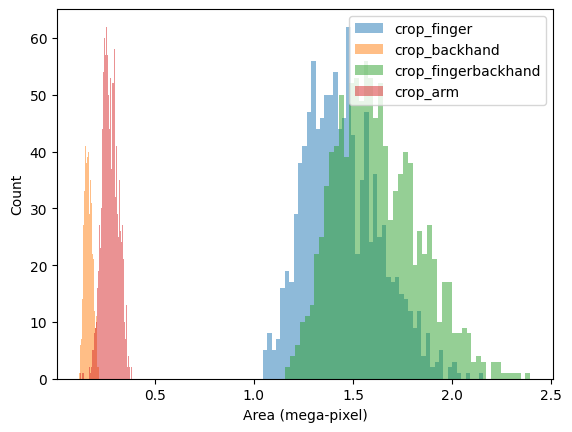

In [46]:
import matplotlib.pyplot as plt

for crop_info in crop_infos:
    plt.hist(result[crop_info], bins=50, alpha=0.5, label=crop_info)

plt.legend()
plt.xlabel('Area (mega-pixel)')
plt.ylabel('Count')